In [72]:
import modele as mod
import sections as s
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

## Caractéristiques de la route

In [73]:
N = 100                        #Taille de la route (en mailles)   
U_init = np.zeros(N)           #Discrétisation de la route
#U_init[0:30] = 100
h = 0.1                         #Taille de chaque maille (en km)
I = 1                          #Nombre de lignes
nom = "Section solo test"

## Caractéristiques de la simulation

In [74]:
p_c = 100.                     #Densité critique (en vh/km)
p_max = 150.                   #Densité max (en vh/km)
V_0 = 50.                      #Vitesse souhaitée (en km/h)                         
flux_entrant = 0            #Flux de véhicules entrant (en vh/h)
#flux_t_entrant = 0            #Flux de temps d'attente
#T = 1.4/3600                   #Temps de réaction
dt =  0.99*(h/V_0)             #CFL

In [75]:
def plus(route):  
    route.flux_entrant+=500


def moins(route):
    if route.flux_entrant - 500>=0:
        route.flux_entrant-=500

## Simulation

In [76]:
#Définition de la route
route = s.section(p_max = p_max, V_0 = V_0, I = I, U = U_init, flux_entrant=flux_entrant, p_c = p_c, nom = nom, sortie=True)

init
I = 1
p_max = 150.0
T = 6.666666666666667e-05
2.0
La route Section solo test a p_c = 75.0


In [77]:
#Définition du modèle
model = mod.model([route], intersections= None, carrefours= None, dt = dt, h = h)

## Visualisation

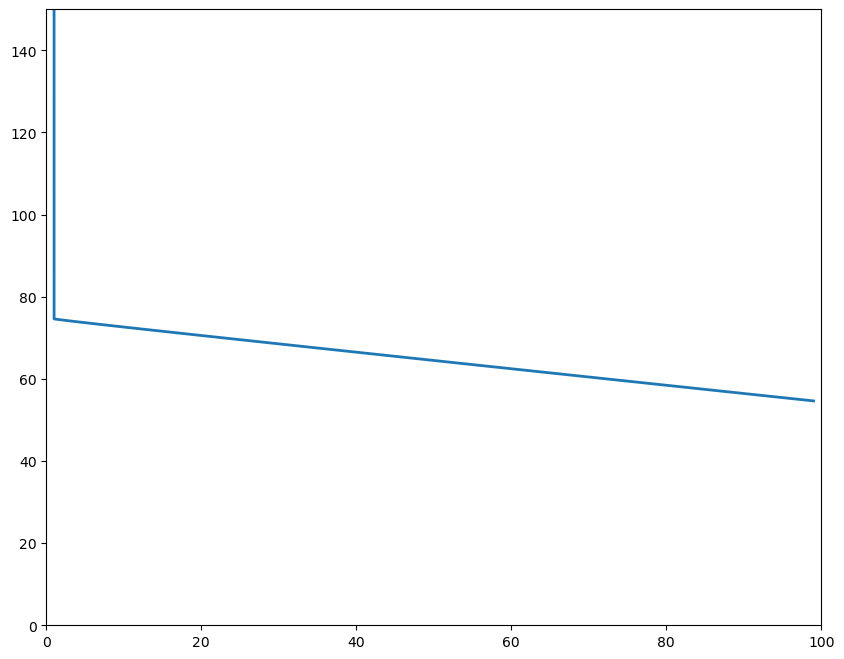

In [78]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(0, N), ylim=(0, 150))
line, = plt.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    model.resoudre()
    if (i+np.random.randint(0,5))%5 == 0:
        plus(route)
    if (i+np.random.randint(0,5))%5 == 0:
        moins(route)
    x = np.linspace(0, N-1, N)
    y = route.U
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, init_func=init, frames=500, interval=50, blit=True)

anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

## Monte Carlo

In [79]:
p_c = 100.                     #Densité critique (en vh/km)
p_max = 150.                   #Densité max (en vh/km)
V_0 = 50.                      #Vitesse souhaitée (en km/h)                         
flux_entrantMC = 1000            #Flux de véhicules entrant (en vh/h)
#flux_t_entrant = 0            #Flux de temps d'attente
#T = 1.4/3600                   #Temps de réaction
dt =  0.99*(h/V_0)             #CFL

In [80]:
routeMC = s.section(p_max = p_max, V_0 = V_0, I = I, U = U_init, flux_entrant=flux_entrantMC, p_c = p_c, nom = nom, sortie=True)

init
I = 1
p_max = 150.0
T = 6.666666666666667e-05
2.0
La route Section solo test a p_c = 75.0


In [81]:
modelMC = mod.model([routeMC], intersections= None, carrefours= None, dt = dt, h = h)

In [82]:
def variation(route_param):
    sigma = np.random.normal(0,0.25)
    if route_param.flux_entrant*(1+sigma)>=0:
        route_param.flux_entrant = route.flux_entrant*(1+sigma)

In [83]:
M = 100

pho_global = []

for i in range(M):
    modelMC.resoudre()
    variation(routeMC)
    pho_global.append(routeMC.U)

[19.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ]
[119.54261017  17.014536     0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.   

[1.20899256e+04 7.35511874e+01 7.26557578e+01 7.18219503e+01
 7.10159900e+01 7.02262092e+01 6.94470886e+01 6.86755530e+01
 6.79097041e+01 6.71482832e+01 6.63904115e+01 6.56354497e+01
 6.48829180e+01 6.41324465e+01 6.33837440e+01 6.26365769e+01
 6.18907550e+01 6.11461212e+01 6.04025441e+01 5.96599129e+01
 5.89181331e+01 5.81771234e+01 5.74368135e+01 5.66971420e+01
 5.59580552e+01 5.52195055e+01 5.44814508e+01 5.37438536e+01
 5.30066804e+01 5.22699008e+01 5.15334876e+01 5.07974162e+01
 5.00616642e+01 4.93262110e+01 4.85910380e+01 4.78561280e+01
 4.71214653e+01 4.63870354e+01 4.56528248e+01 4.49188211e+01
 4.41850128e+01 4.34513892e+01 4.27179402e+01 4.19846566e+01
 4.12515295e+01 4.05185507e+01 3.97857126e+01 3.90530078e+01
 3.83204296e+01 3.75879713e+01 3.68556269e+01 3.61233904e+01
 3.53912564e+01 3.46592193e+01 3.39272741e+01 3.31954158e+01
 3.24636395e+01 3.17319407e+01 3.10003146e+01 3.02687568e+01
 2.95372629e+01 2.88058282e+01 2.80744483e+01 2.73431186e+01
 2.66118344e+01 2.588059

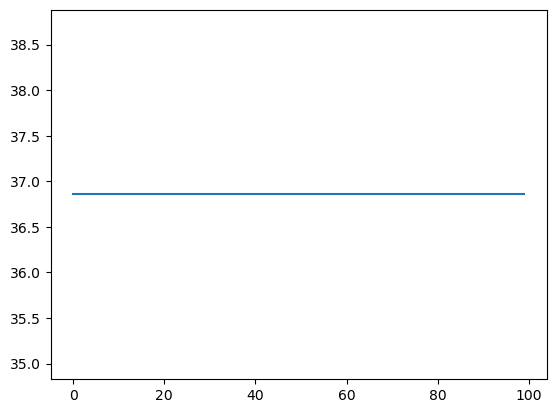

In [84]:
x = 50
pho_x = []
for pho in pho_global:
    pho_x.append(pho[x])
    print(pho)
plt.plot(pho_x)

In [85]:
np.shape(pho_global)

(100, 100)

In [86]:
pho_global

[array([1.20899256e+04, 7.35511874e+01, 7.26557578e+01, 7.18219503e+01,
        7.10159900e+01, 7.02262092e+01, 6.94470886e+01, 6.86755530e+01,
        6.79097041e+01, 6.71482832e+01, 6.63904115e+01, 6.56354497e+01,
        6.48829180e+01, 6.41324465e+01, 6.33837440e+01, 6.26365769e+01,
        6.18907550e+01, 6.11461212e+01, 6.04025441e+01, 5.96599129e+01,
        5.89181331e+01, 5.81771234e+01, 5.74368135e+01, 5.66971420e+01,
        5.59580552e+01, 5.52195055e+01, 5.44814508e+01, 5.37438536e+01,
        5.30066804e+01, 5.22699008e+01, 5.15334876e+01, 5.07974162e+01,
        5.00616642e+01, 4.93262110e+01, 4.85910380e+01, 4.78561280e+01,
        4.71214653e+01, 4.63870354e+01, 4.56528248e+01, 4.49188211e+01,
        4.41850128e+01, 4.34513892e+01, 4.27179402e+01, 4.19846566e+01,
        4.12515295e+01, 4.05185507e+01, 3.97857126e+01, 3.90530078e+01,
        3.83204296e+01, 3.75879713e+01, 3.68556269e+01, 3.61233904e+01,
        3.53912564e+01, 3.46592193e+01, 3.39272741e+01, 3.319541